In [2]:
import tensorflow as tf
import json
import numpy as np
import pandas as pd

from google.cloud import bigquery
from google.cloud import storage

from google.cloud import aiplatform


import matplotlib.pyplot as plt
import seaborn as sns

#https://developers.google.com/machine-learning/testing-debugging/metrics/metrics
#https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall
#https://keras.io/api/metrics/
#https://developers.google.com/machine-learning/crash-course/classification/accuracy


In [3]:
print(tf.__version__)

2.11.1


In [4]:
unUsedColtoPredict=['id','severity','severity_id','severity_name']  # delete cols after prediction
isLocalModel=True


isBQToCSV=True


modelFile_endPoint=1 
#1=local(dev)/gcs(clound function) and 2=vertext

localFile=True

projectId='pongthorn'
dataset_id='DemoSMartDW'

# table_id='new_incident'  # for new coming data
table_id='test_incident'   # for test data

REGION="asia-southeast1"

#PATH_FOLDER_ARTIFACTS="model" 
PATH_FOLDER_ARTIFACTS='model_tuned'

In [5]:
bqclient= bigquery.Client(project=projectId)
def download_table(bq_table_uri: str):

    prefix = "bq://"
    if bq_table_uri.startswith(prefix):
        bq_table_uri = bq_table_uri[len(prefix) :]

    table = bigquery.TableReference.from_string(bq_table_uri)
    rows = bqclient.list_rows(table)
    return rows.to_dataframe()

dfNewData=download_table(f"{projectId}.{dataset_id}.{table_id}")

# test data

dfNewData=dfNewData.rename(columns={'label_multi_severity':'severity'})
dfNewData=dfNewData.drop(columns=['label_binary_severity'])

if 'id' not in dfNewData.columns.to_list():
    dfNewData=dfNewData.reset_index(drop=True)
    dfNewData = dfNewData.reset_index(level=0)
    dfNewData.rename(columns={"index": "id"},inplace=True)
    dfNewData['id']=dfNewData['id']+1
print(dfNewData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         227 non-null    int64  
 1   severity_id                227 non-null    Int64  
 2   severity_name              227 non-null    object 
 3   sla                        227 non-null    object 
 4   product_type               227 non-null    object 
 5   brand                      227 non-null    object 
 6   service_type               227 non-null    object 
 7   incident_type              227 non-null    object 
 8   open_to_close_hour         227 non-null    float64
 9   response_to_resolved_hour  227 non-null    float64
 10  severity                   227 non-null    Int64  
dtypes: Int64(2), float64(2), int64(1), object(6)
memory usage: 20.1+ KB
None


In [6]:
dfNewData.sample(5)

,id,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,severity
173,174,2,Major,24x7 4Hrs Response Time,Software,VMWare,Incident,General Incident,1.350000,1.216667,2
39,40,2,Major,24x7 4Hrs Resolution Time,Server,HPE,Incident,Hard Disk Drive Failure,1.816667,0.716667,2
43,44,2,Major,24x7 4Hrs Response Time,Server,HPE,Incident,General Incident,183.883333,1.933333,2
55,56,3,Minor,24x7 4Hrs Resolution Time,Server,HPE,Request,General Incident,2.800000,1.916667,1
73,74,1,Critical,24x7 4Hrs Resolution Time,Storage,NetApp,Incident,Hard Disk Drive Failure,28.250000,28.166667,3


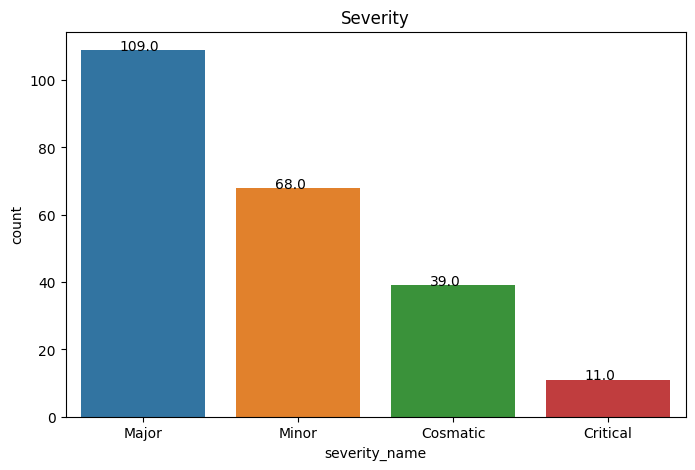

In [7]:
def plot_class(df):
    fig , ax = plt.subplots(figsize=(8,5))
    ax =sns.countplot(x='severity_name', data=df,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title('Severity')
    plt.show()
    
plot_class(dfNewData)

In [8]:
pdPrediction=pd.DataFrame(columns=['_id','_predict_severity'])
pdPrediction

,_id,_predict_severity


# Load Model from Directory to Predict

In [9]:
if modelFile_endPoint==1 :   
    model = tf.keras.models.load_model(PATH_FOLDER_ARTIFACTS)    
    print(f"Load from {PATH_FOLDER_ARTIFACTS}")
    # model.summary()

    
    for  row_dict in dfNewData.to_dict(orient="records"):
          incident_id=row_dict['id']
          print(f"{incident_id} - {row_dict['severity']}({row_dict['severity_name']})") 
          for key_removed in unUsedColtoPredict:
           row_dict.pop(key_removed)
          # print(row_dict)  

          input_dict = {name: tf.convert_to_tensor([value]) for name, value in row_dict.items()}


          predictionResult = model.predict(input_dict)

          prob = tf.nn.softmax(predictionResult)
          prob_pct=(100 * prob)  
          _class = tf.argmax(predictionResult,-1).numpy()[0]
          
          pdPrediction =pd.concat([pdPrediction,pd.DataFrame.from_dict([{'_id':incident_id, '_predict_severity':_class}])] )
          # print(input_dict)  
            
          print(f"{prob_pct} %   as {_class}")     
          print("======================================================================================")

    dfPredictData=pd.merge(dfNewData,pdPrediction,how='inner',left_on='id',right_on='_id')
    dfPredictData=dfPredictData.drop(columns=['_id'])
    dfPredictData=dfPredictData[['id','_predict_severity','severity','severity_name']]


Load from model_tuned
1 - 2(Major)
1/1 [==============================] - 1s 703ms/step
[[19.070097 28.355783 33.63133  18.942793]] %   as 2
2 - 2(Major)
1/1 [==============================] - 0s 68ms/step
[[19.126043 29.115072 32.795055 18.963835]] %   as 2
3 - 1(Minor)
1/1 [==============================] - 0s 72ms/step
[[19.03533  24.20254  35.95404  20.808088]] %   as 2
4 - 0(Cosmatic)
1/1 [==============================] - 0s 71ms/step
[[18.701866 44.315617 19.00826  17.97425 ]] %   as 1
5 - 3(Critical)
1/1 [==============================] - 0s 65ms/step
[[19.387957 23.059042 27.083332 30.469671]] %   as 3
6 - 3(Critical)
1/1 [==============================] - 0s 55ms/step
[[19.353567 23.127928 26.466257 31.052246]] %   as 3
7 - 3(Critical)
1/1 [==============================] - 0s 70ms/step
[[17.77426  18.762857 45.697517 17.765362]] %   as 2
8 - 3(Critical)
1/1 [==============================] - 0s 62ms/step
[[19.38628  23.062216 27.050957 30.500546]] %   as 3
9 - 3(Critical)
1/

# Load Model from Online EndPpint to Predict

In [12]:
# Load model by refering to vertext-ai registry and create endpoint
isEndpointAvaiable=False
listRequestData=[]
try:
    ENDPOINT_ID="2704182877817405440"
    endpoint = aiplatform.Endpoint(endpoint_name=f"projects/{projectId}/locations/{REGION}/endpoints/{ENDPOINT_ID}")
    print(endpoint)
    isEndpointAvaiable=True
except Exception as error:
    print(str(error))
    
if modelFile_endPoint==2 and isEndpointAvaiable==True :

    for data in dfNewData.to_dict(orient="records"):
        incident_id=data['id']
        severity=data['severity']
        severity_name=data['severity_name']
        # convert dict to tf format
        request_data = {key : [value] for key,value in data.items() }
        for key_removed in unUsedColtoPredict:
           request_data.pop(key_removed)
        request_data = json.dumps(request_data)
        listRequestData.append(request_data)
        print(request_data)

        response = endpoint.predict([request_data])
        y_predicted = np.argmax(response.predictions, axis=1)
        predictionResult=response[0][0]
        print(predictionResult)
        print(y_predicted)

        pdPrediction =pd.concat([pdPrediction,pd.DataFrame.from_dict([{'_id':incident_id, '_predict_severity':y_predicted[0]}])] )
        print("======================================================================================")

    dfPredictData=pd.merge(dfNewData,pdPrediction,how='inner',left_on='id',right_on='_id')
    dfPredictData=dfPredictData.drop(columns=['_id'])
    dfPredictData=dfPredictData[['id','_predict_severity','severity','severity_name']]       
else:
     print("No endpoint to predict  as online predction")     

404 Endpoint projects/pongthorn/locations/asia-southeast1/endpoints/2704182877817405440 is not found.
No endpoint to predict  as online predction


# Classification Rerport

In [13]:
from sklearn.metrics import confusion_matrix,classification_report


In [14]:
dfPredictData

,id,_predict_severity,severity,severity_name
0,1,2,2,Major
1,2,2,2,Major
2,3,2,1,Minor
3,4,1,0,Cosmatic
4,5,3,3,Critical
...,...,...,...,...
222,223,1,1,Minor
223,224,0,0,Cosmatic
224,225,0,0,Cosmatic
225,226,0,0,Cosmatic


In [15]:
className=list(set().union(list(dfPredictData['severity'].unique()),list(dfPredictData['_predict_severity'].unique())))
actualClass=[  f'actual-{x}' for x in  className]
predictedlClass=[  f'predcited-{x}' for x in className]

y_true=list(dfPredictData['severity'])
y_pred=list(dfPredictData['_predict_severity'])
cnf_matrix = confusion_matrix(y_true,y_pred)
cnf_matrix

# #index=actual , column=prediction
cm_df = pd.DataFrame(cnf_matrix,
                     index = actualClass, 
                     columns = predictedlClass)
cm_df

,predcited-0,predcited-1,predcited-2,predcited-3
actual-0,31,3,5,0
actual-1,3,28,36,1
actual-2,3,14,88,4
actual-3,0,1,4,6


In [16]:

print(classification_report(y_true, y_pred, labels=className))

              precision    recall  f1-score   support

           0       0.84      0.79      0.82        39
           1       0.61      0.41      0.49        68
           2       0.66      0.81      0.73       109
           3       0.55      0.55      0.55        11

    accuracy                           0.67       227
   macro avg       0.66      0.64      0.64       227
weighted avg       0.67      0.67      0.66       227

